In [1]:
import cv2
import numpy as np 
from matplotlib import pyplot as plt
import math
from math import *
import random

In [2]:
def show(img):
    plt.imshow(img)
    plt.show()
def showg(img):
    plt.imshow(img,cmap='gray')
    plt.show()
def imshow(img):
    cv2.imshow('ImageWindow',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [3]:
img = cv2.imread("check.bmp")
simA = cv2.imread("simA.jpg")
simB = cv2.imread("simB.jpg")
transA = cv2.imread("transA.jpg")
transB = cv2.imread("transB.jpg")

In [4]:
bsimA = cv2.GaussianBlur(simA,(3,3),0)
btransA = cv2.GaussianBlur(transA,(3,3),0)

In [5]:
def derivatives(img):
    scale = 1
    delta = 0
    ddepth = cv2.CV_16S
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    return grad_x,grad_y

In [6]:
def harris(img,x,y):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    Ixx = x * x
    Iyy = y * y
    Ixy = x * y
    Ixx = np.asarray(Ixx)
    Iyy = np.asarray(Iyy)
    Ixy = np.asarray(Ixy)
    w = 3
    off = int(w/2)
    h,w = img.shape
    Sxx = np.zeros(shape=(h,w))
    Syy = np.zeros(shape=(h,w))
    Sxy = np.zeros(shape=(h,w))
    for i in range (off,h-off):
        for j in range(off,w-off):
            Sxx[i,j] = np.sum(Ixx[i-off:i+1+off, j-off:j+1+off])
            Syy[i,j] = np.sum(Iyy[i-off:i+1+off, j-off:j+1+off])
            Sxy[i,j] = np.sum(Ixy[i-off:i+1+off, j-off:j+1+off])
    det = (Sxx*Syy) - (Sxy**2)
    trace = Sxx+Syy
    k = 0.04
    R = det - k*(trace**2)
    return R

In [7]:
def hit(image, temp,a,b):
    c = 0
    h_t, w_t = temp.shape
    for u in range(0,w_t):
        for v in range(0,h_t):
            if image[b-h_t//2+v,a-w_t//2+u]>c:
                c=image[b-h_t//2+v,a-w_t//2+u]
    return c
def dilation(img,t):
    h,w  = img.shape
    h_t, w_t = t.shape
    empty = np.zeros((h,w))
    for i in range(w_t//2,w-w_t//2):
        for j in range(h_t//2,h-h_t//2):
            c = hit(img,t,i,j)
            empty[j,i] = c
    return empty  

In [8]:
def threshNMS(img,R):
    Rf = R.flatten()
    mx = Rf.max()
    mx =  0.2*mx
    h,w = R.shape
    R1 = np.zeros(shape=(h,w))
#     img = cv2.imread("simA.jpg")
    h,w = R.shape
    for i in range(h):
        for j in range(w):
            if(R[i][j]>mx):
                R1[i][j] = R[i][j]
    t = np.ones(shape=(5,5))
    dR1 = dilation(R1,t)
    h,w = R1.shape
    NMS = np.zeros((h,w))
    count = 0
    for i in range(h):
        for j in range(w):
            if dR1[i][j]==R1[i][j] and dR1[i][j]!=0:
                NMS[i][j]=1
#                 img[i][j] = [255,0,0]
                count+=1
#                 print(i,j)
#     showg(img)
#     print(count)
    return NMS,count

In [9]:
def keypoints(NMS,x,y):
    kps = []
    tans = cv2.phase(np.array(x, np.float32), np.array(y, dtype=np.float32), angleInDegrees=True)
    count = 0
    h,w = NMS.shape
    for i in range(h):
        for j in range(w):
            if NMS[i][j]>0:
                count+=1
                point = cv2.KeyPoint(x=j,y=i, _size = 3, _angle = tans[i][j], _octave=0)
                kps.append(point)
#     print(count)
    return kps
                

In [10]:
def sift1(img):
    x,y = derivatives(img)
    showg(x)
    showg(y)
    R = harris(img,x,y)
    C, num = threshNMS(img, R)
#     print(num)
    points = keypoints(C,x,y)
    sift = cv2.xfeatures2d.SIFT_create()
    points,descs = sift.compute(img,points)
    return points,descs

In [11]:
def match(img1,img2):
    sift = cv2.xfeatures2d.SIFT_create()
    pointsA, descA = sift1(img1)
    pointsB, descB = sift1(img2)
    bfm = cv2.BFMatcher()
    matches = bfm.match(descA, descB)
    matches = sorted(matches, key = lambda x:x.distance)
    img3 = cv2.drawMatches(img1,pointsA,img2,pointsB,matches[:10], None,flags=2)
    return img3,matches[:10],pointsA,pointsB

# for TransA , TransB

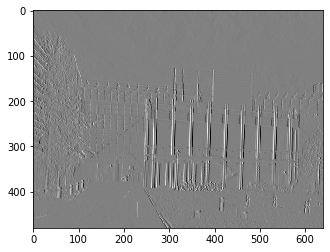

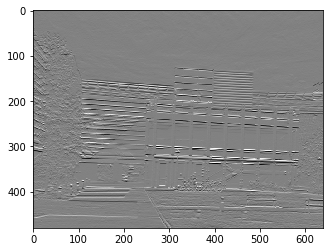

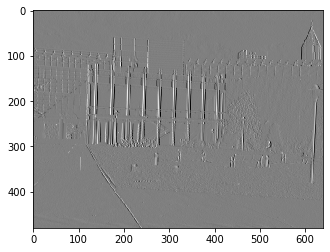

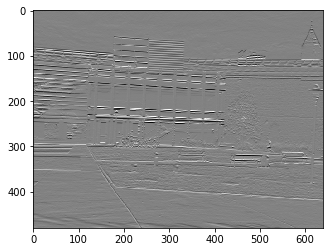

In [33]:
# transA and transB
image,matches,kp1,kp2 = match(transA,transB)

In [43]:
imshow(image)

In [44]:
list_kp1 = []
list_kp2 = []

for mat in matches:

    # Get the matching keypoints for each of the images
    img1_idx = mat.queryIdx
    img2_idx = mat.trainIdx

    # x - columns
    # y - rows
    # Get the coordinates
    (x1, y1) = kp1[img1_idx].pt
    (x2, y2) = kp2[img2_idx].pt

    # Append to each list
    list_kp1.append((x1, y1))
    list_kp2.append((x2, y2))

In [36]:
l = len(list_kp1)

In [37]:
csmx = 0
diff = [0,0]
idx = -1
for i in range(5):
    j = random.randrange(0,10,1)
    d = [0,0]
    cs = 0
    print(list_kp1[j],list_kp2[j])
    d[0] = list_kp2[j][0]-list_kp1[j][0]
    d[1] = list_kp2[j][1]-list_kp1[j][1]
    for k in range(l):
        d1 = list_kp2[k][0]-list_kp1[k][0]
        d2 = list_kp2[k][1]-list_kp1[k][1]
        if abs(d1-d[0])<20 and abs(d2-d[1]<20):
            cs+=1
    if(cs>csmx):
        csmx = cs
        diff = d
        idx = j
csmx

(608.0, 212.0) (443.0, 135.0)
(608.0, 212.0) (443.0, 135.0)
(356.0, 361.0) (217.0, 268.0)
(356.0, 361.0) (217.0, 268.0)
(216.0, 347.0) (92.0, 256.0)


7

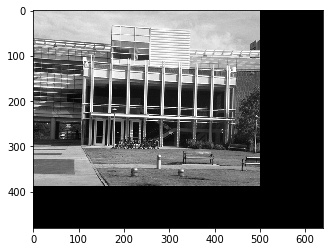

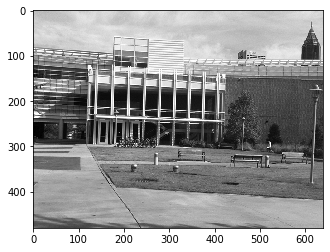

7

In [38]:
T = np.float32([[1, 0, diff[0]], [0, 1, diff[1]]]) 
h,w = transA.shape[:2]
ttransA = cv2.warpAffine(transA, T, (w, h))
show(ttransA)
show(transB)
csmx

In [39]:
T

array([[   1.,    0., -139.],
       [   0.,    1.,  -93.]], dtype=float32)

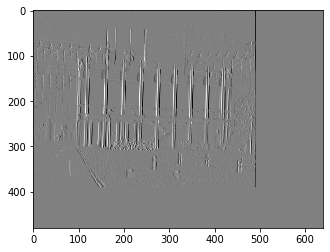

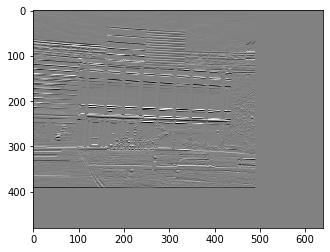

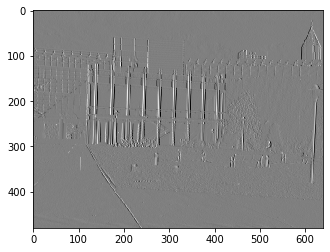

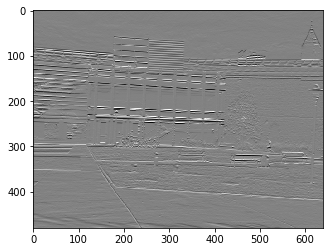

In [31]:
image1,matches1,kp11,kp21 = match(ttransA,transB)

In [32]:
imshow(image1)

# for simA simB

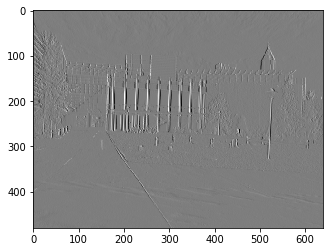

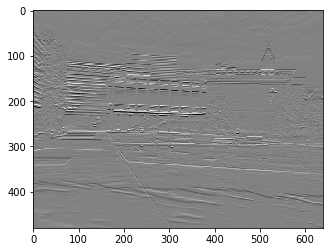

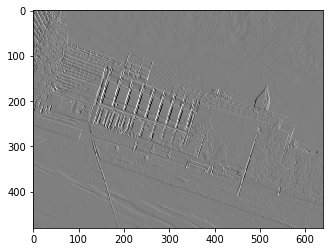

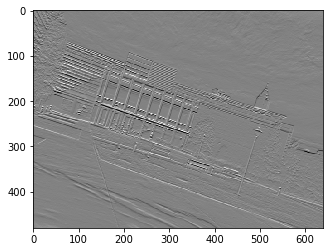

In [21]:
imageS,matchesS,kp1S,kp2S = match(simA,simB)

In [22]:
imshow(imageS)

In [23]:
list_kp1 = []
list_kp2 = []

for mat in matchesS:

    # Get the matching keypoints for each of the images
    img1_idx = mat.queryIdx
    img2_idx = mat.trainIdx

    # x - columns
    # y - rows
    # Get the coordinates
    (x1, y1) = kp1S[img1_idx].pt
    (x2, y2) = kp2S[img2_idx].pt

    # Append to each list
    list_kp1.append((x1, y1))
    list_kp2.append((x2, y2))

In [24]:
list_kp1 = np.float32(list_kp1)
list_kp2 = np.float32(list_kp2)
print(list_kp1)

[[315. 262.]
 [ 63. 278.]
 [283. 165.]
 [322. 175.]
 [352. 132.]
 [248. 398.]
 [142. 174.]
 [ 84. 325.]
 [235. 300.]
 [  7. 126.]]


In [45]:
ansl1 = []
ansl2 = [] 
mx = 0
for it in range(10):
    idx = random.sample(range(0, 10), 3)
    list1 = []
    list2 = []
    list1.append(list_kp1[idx[0]])
    list1.append(list_kp1[idx[1]])
    list1.append(list_kp1[idx[2]])
    list2.append(list_kp2[idx[0]])
    list2.append(list_kp2[idx[1]])
    list2.append(list_kp2[idx[2]])
    list1 = np.float32(list1)
    list2 = np.float32(list2)
#     print(list1)
#     print(list2)
    T = cv2.getAffineTransform(list1,list2)
    X = list_kp1
    n,m = X.shape # for generality
    X0 = np.ones((n,1))
    Xnew = np.hstack((X,X0))
    Xnew = np.transpose(Xnew)
    A = np.dot(T,Xnew)
    A = np.transpose(A) 
    sub = np.subtract(A,list_kp2)
#     print(sub)
    count = 0
#     print(A.shape[0])
    for i in range(A.shape[0]):
        if abs(sub[i][0])<10 and abs(sub[i][1])<10:
            count+=1
    print(count)
    if count > mx:
        mx=count
        ansl1 = list1
        ansl2 = list2

AttributeError: 'list' object has no attribute 'shape'

In [46]:
T = cv2.getAffineTransform(ansl1,ansl2)
T

TypeError: src is not a numpy array, neither a scalar

In [27]:
img = cv2.warpAffine(simA,T,(simA.shape[1],simA.shape[0]))

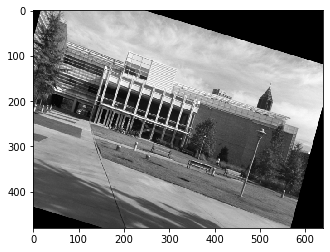

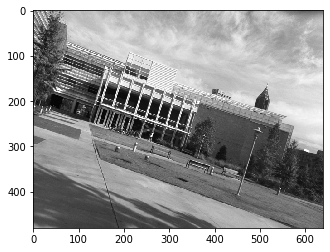

In [28]:
show(img)
show(simB)

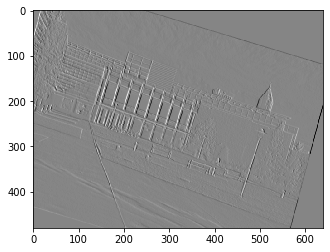

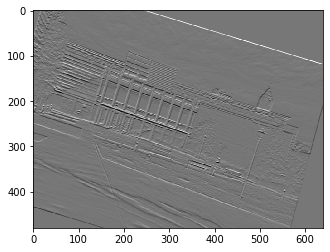

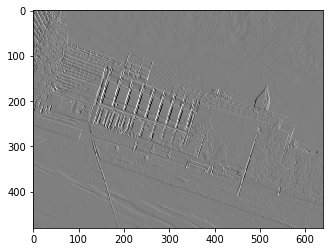

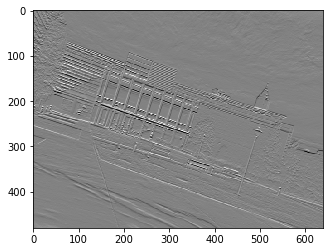

In [29]:
imageS1,matchesS1,kp1S1,kp2S1 = match(img,simB)

In [47]:
imshow(imageS1)